In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import requests
import json

from matplotlib import font_manager

# import nodes-values-relation tags

In [3]:
JSON_folder = "json_data/ncn_japan/"

with open(JSON_folder + 'ways.json') as f:
    data = json.load(f)
df_ways = pd.json_normalize(data)

# Extract the id, lat, lon, and expand the tags dictionary
#df_expanded = pd.json_normalize(data, 'tags', ['id', 'lat', 'lon'], sep='_')

In [4]:
df_ways.columns = df_ways.columns.str.replace('tags.', '', regex=False)
df_ways = df_ways.drop(columns=[col for col in df_ways.columns if 'name' in col])


# Tags NAN frequency

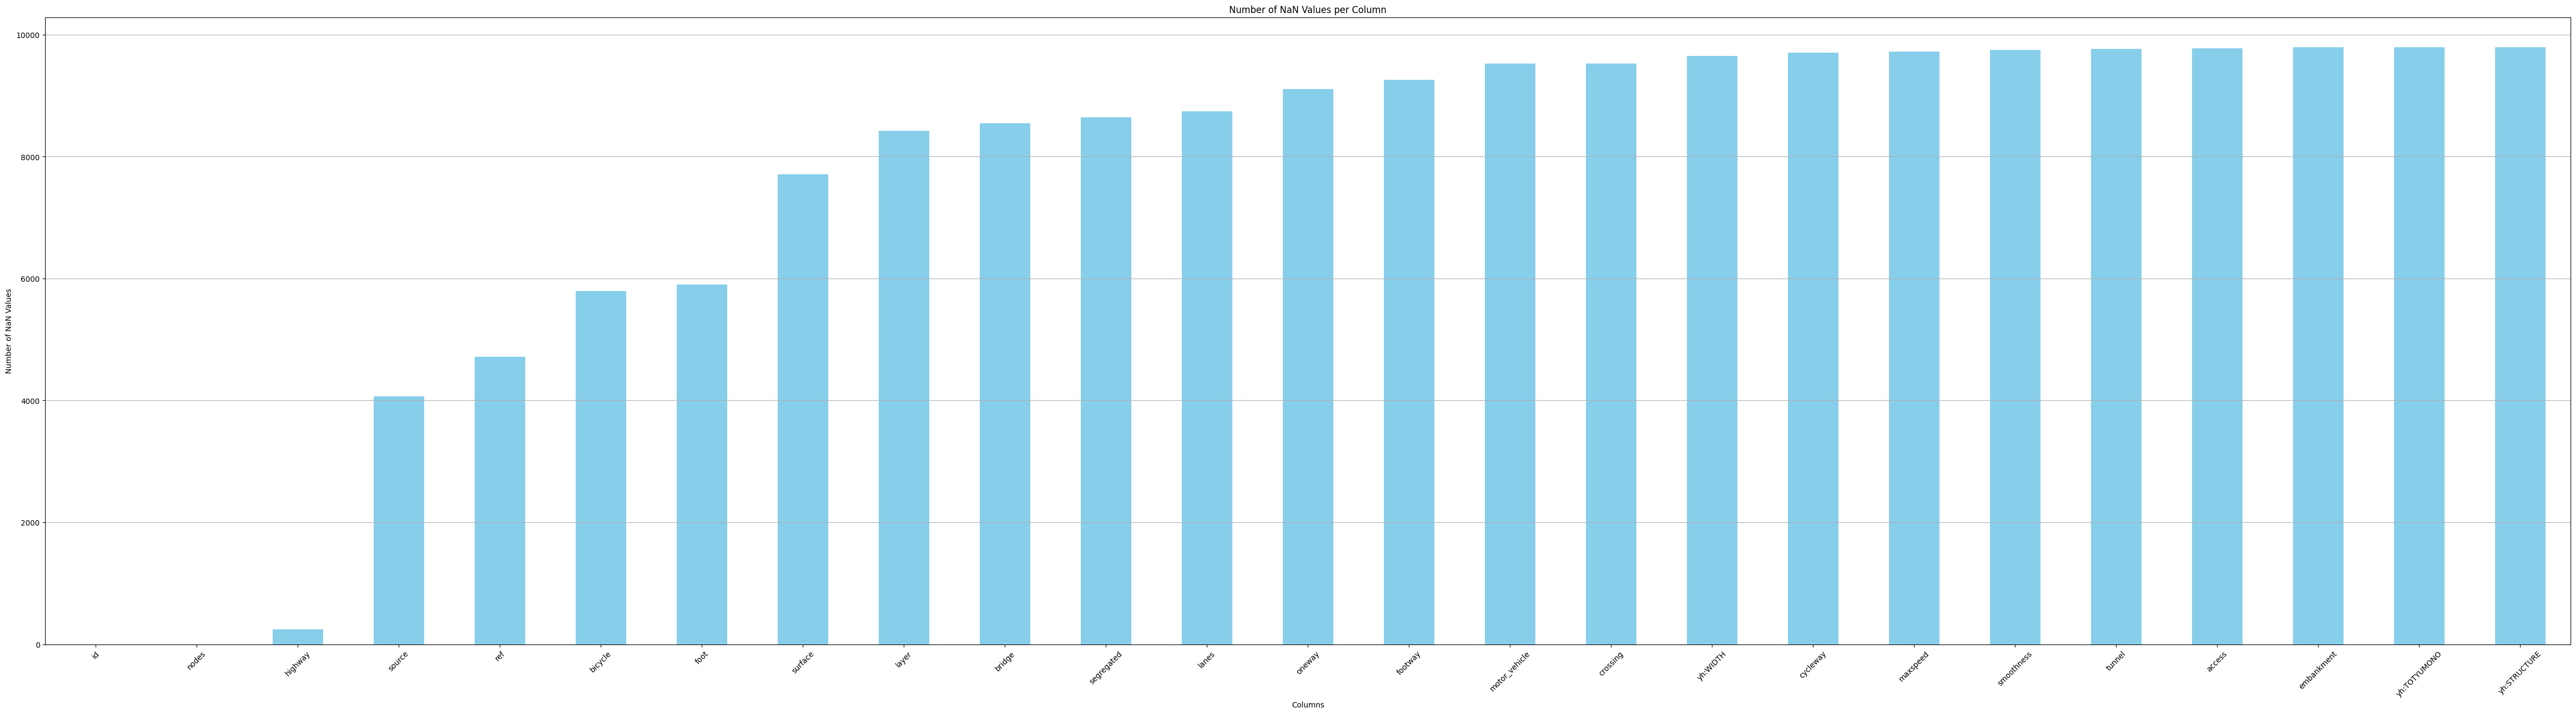

In [8]:
nan_count_nodes = df_ways.isna().sum().sort_values()

plt.figure(figsize=(60, 15))
nan_count_nodes[0:25].plot(kind='bar', color='skyblue')

plt.title('Number of NaN Values per Column')
plt.xlabel('Columns')
plt.ylabel('Number of NaN Values')
plt.xticks(rotation=45)
plt.grid(axis='y')

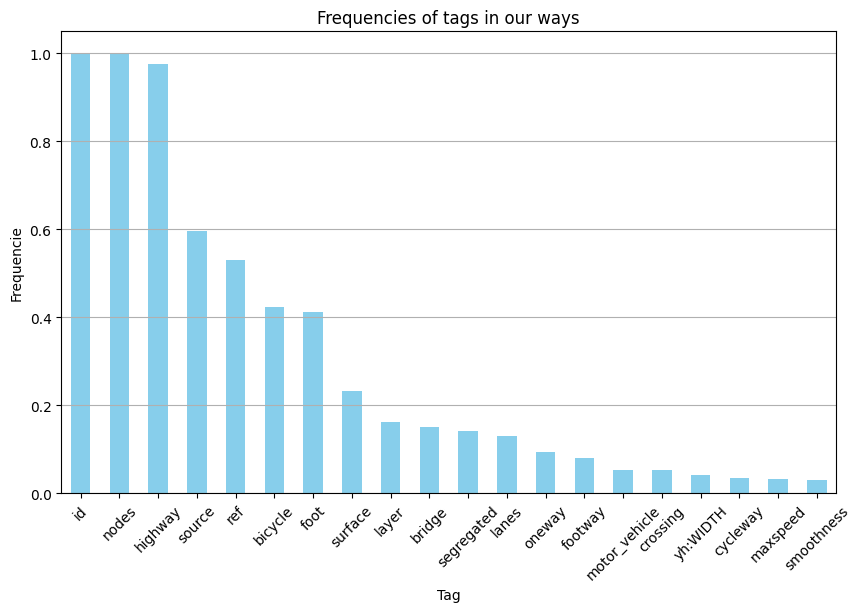

In [9]:
nan_count_ways = df_ways.isna().sum().sort_values()
nan_count_ways = (df_ways.shape[0] - nan_count_ways )/df_ways.shape[0]

plt.figure(figsize=(10, 6))
nan_count_ways[0:20].plot(kind='bar', color='skyblue')

plt.title('Frequencies of tags in our ways')
plt.xlabel('Tag')
plt.ylabel('Frequencie')
plt.xticks(rotation=45)
plt.grid(axis='y')

#plt.savefig('Image/Nan_values_ways.png')

# Tags NAN frequency, for a specific tag=value

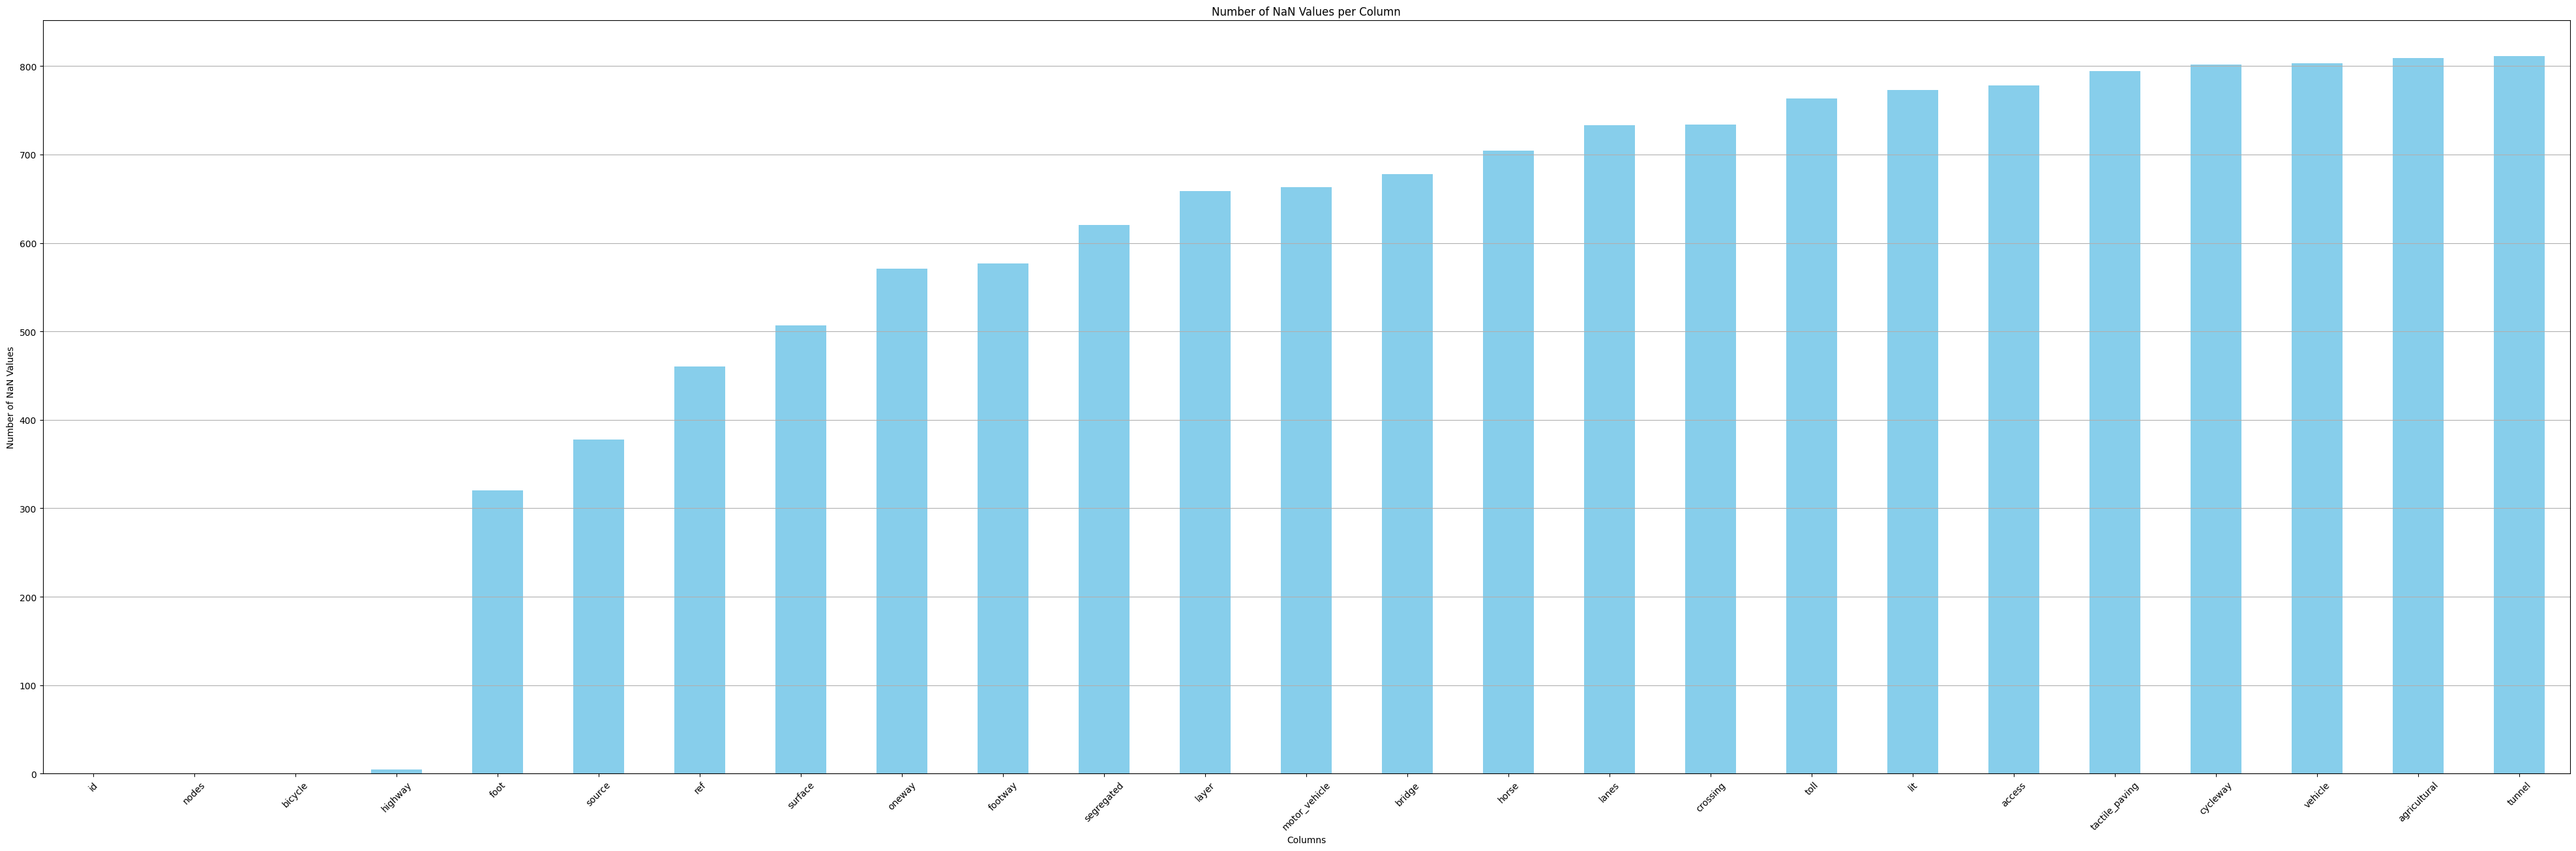

In [10]:
bicycle_tags = df_ways[df_ways["bicycle"] == "yes"]
bicycle_count = bicycle_tags.isna().sum().sort_values()

plt.figure(figsize=(50, 15))
bicycle_count[0:25].plot(kind='bar', color='skyblue')

plt.title('Number of NaN Values per Column')
plt.xlabel('Columns')
plt.ylabel('Number of NaN Values')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Tags Frequency in NCN compare to frequency in all japan

## Ways

### Select important tags

In [11]:
tags_list = df_ways.columns[2:]

tag_ways = {}
for tag in tags_list:
    values = df_ways[tag].dropna().unique().tolist()
    if len(values) < 20 :
        tag_ways[tag] = values

### Extract global osm statistics for each of our tags

In [12]:
# Taginfo API endpoint
base_url = 'https://taginfo.openstreetmap.org/api/4/tag/stats'

# Function to fetch statistics for a key-value pair
def fetch_taginfo_stats(key, value):
    url = f"{base_url}?key={key}&value={value}"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch data for key={key}, value={value}. Status code: {response.status_code}")
        return None

stat_ways_global = {}

bool_load = False

# Iterate over keys and their values
if bool_load==True:
    i=0
    n_key=len(tag_ways.keys())
    for key, values in tag_ways.items():
        print(f"{i/n_key*100}%")
        i+=1
        dic_ways = {}
        for value in values:
            stats = fetch_taginfo_stats(key, value) 
            if stats:
                dic_ways[value] = stats['data'][2]['count_fraction']
            else :
                print("no stat for ", value)
        stat_ways_global[key] = dic_ways

        with open(JSON_folder + 'stat_ways.json', 'w') as json_file:
            json.dump(stat_ways_global, json_file)

else :
    with open(JSON_folder + 'stat_ways.json', 'r') as json_file:
        stat_ways_global = json.load(json_file)



### Compare frequency

In [13]:
#n_total_node = 240_455_144

stat_ways_ncn = {}
df_ways_cut = df_ways[tag_ways.keys()]

for col in df_ways_cut.columns:
    dic_ways = {}
    for value, count in df_ways_cut[col].dropna().value_counts().items():
        dic_ways[value] = count/df_ways.shape[0]
    stat_ways_ncn[col] = dic_ways

In [14]:
df_stat_ways = pd.DataFrame(index=["stat ncn", "stat global"])
for tag in stat_ways_ncn.keys():
    for value in stat_ways_ncn[tag].keys():
        stat_ncn = stat_ways_ncn[tag][value]
        stat_all = stat_ways_global[tag][value]
        df_stat_ways[tag + "=" + value] = [stat_ncn, stat_all]

C:\Users\matba\AppData\Local\Temp\ipykernel_21160\2748854866.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stat_ways[tag + "=" + value] = [stat_ncn, stat_all]
C:\Users\matba\AppData\Local\Temp\ipykernel_21160\2748854866.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_stat_ways[tag + "=" + value] = [stat_ncn, stat_all]
C:\Users\matba\AppData\Local\Temp\ipykernel_21160\2748854866.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

In [15]:
df_stat_ways = df_stat_ways.loc[:,df_stat_ways.loc["stat global"] > 0.0001]
df_stat_ways.loc["relative error"] = (df_stat_ways.loc["stat ncn"])/df_stat_ways.loc["stat global"]
sort_ways = df_stat_ways.T["relative error"].sort_values(ascending=False)

Text(0.5, 1.0, 'Frequency')

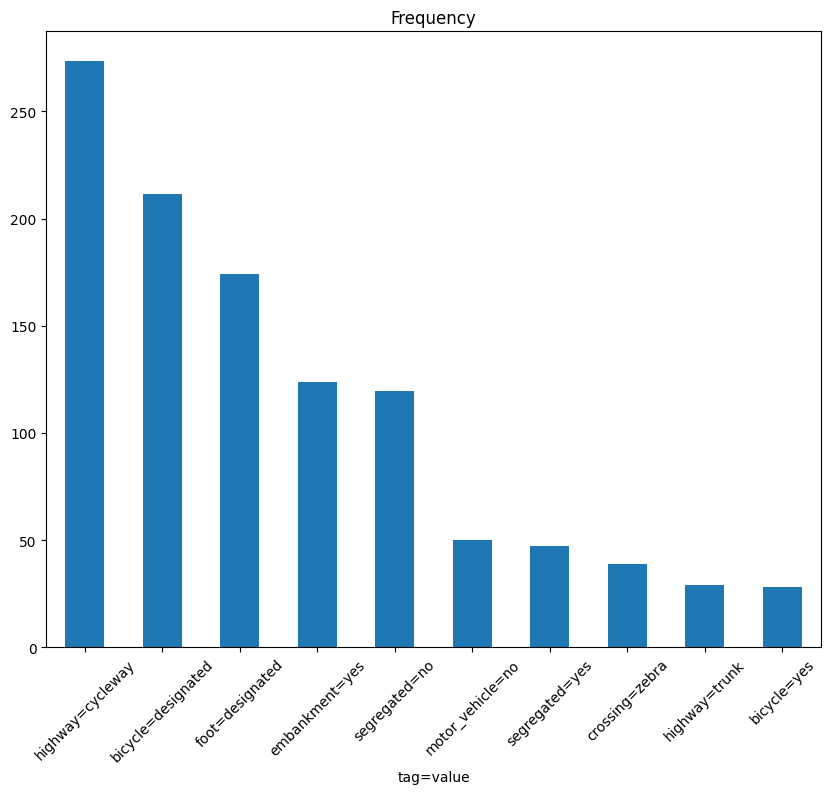

In [16]:
sort_ways[sort_ways > 10].iloc[:10].plot(y="relative error", kind="bar", figsize=(10,8), rot=45 )
plt.xlabel('tag=value')
plt.ylabel('')
plt.title('Frequency')

#plt.savefig('Image/Selected_tags.png')

Text(0.5, 1.0, 'Frequency')

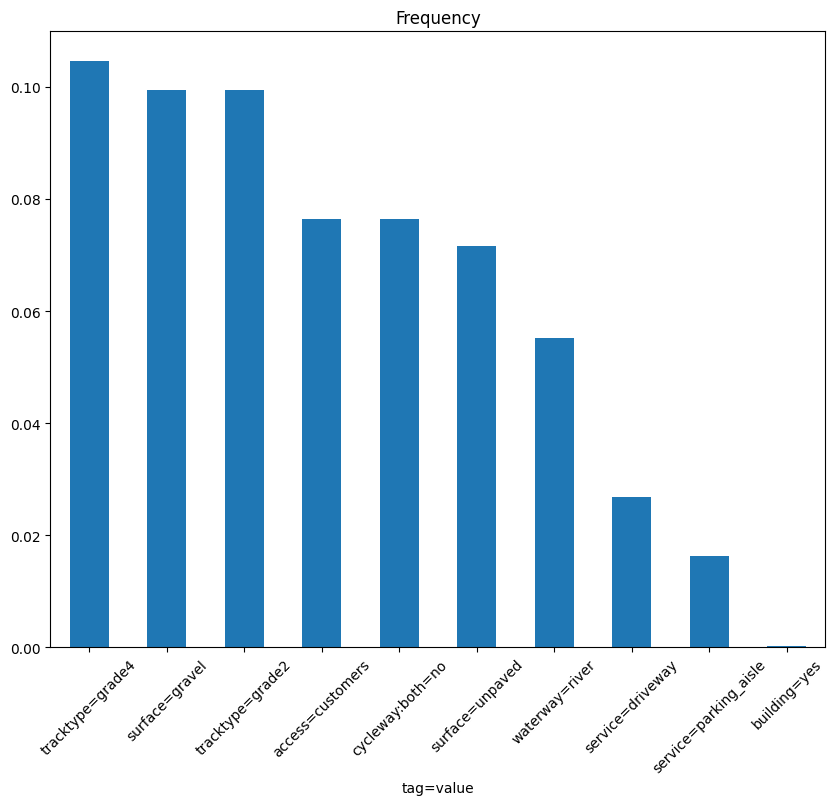

In [17]:
sort_ways.iloc[-10:].plot(y="relative error", kind="bar", figsize=(10,8), rot=45 )
plt.xlabel('tag=value')
plt.ylabel('')
plt.title('Frequency')

#plt.savefig('Image/Negative_freq_tags.png')

# Scoring (Not finished)

## Extract kansai road with the selected tags
- scoring fonction : somme pondéré par la présence du tag dans les nationnal road

In [18]:
JSON_folder_2 = "json_data/selected_ways/"
with open(JSON_folder_2 + 'ways.json') as f:
    data = json.load(f)
df_selected_ways = pd.json_normalize(data)

df_selected_ways.columns = df_selected_ways.columns.str.replace('tags.', '', regex=False)
df_selected_ways["score"] = 0.0

In [19]:
# parcour every important tags, add score for each line.
keys = [string.split("=")[0] for string in sort_ways.index.values]
filtered_keys = [col for col in keys if col in df_selected_ways.columns]
filtered_keys = list(set(filtered_keys))
df_filter = df_selected_ways[filtered_keys]

for kv, freq in sort_ways.items():
    key = kv.split("=")[0]
    value = kv.split("=")[1]
    if key in df_filter.columns:
        df_selected_ways.loc[df_filter[key] == value, "score"] += freq

In [20]:
with open(JSON_folder_2 + 'nodes.json') as f:
    data = json.load(f)

# Allowed keys
allowed_keys = {'lat', 'lon', 'id'}

# Filter dictionaries
data = [{k: v for k, v in d.items() if k in allowed_keys} for d in data]

df_nodes_coords = pd.json_normalize(data)
df_nodes_coords["score"] = 0.0

In [29]:
df_nodes_coords[["lat", "lon"]].rename(columns={"lat": "latitude", "lon": "longitude"}).to_json("./Data/dataInJason/dataInJason/input_test.json", orient='records')

In [30]:
df_selected_ways = df_selected_ways.sort_values(by="score", ascending=False)

In [33]:
top_roads = df_selected_ways.iloc[0:1000]
for nodes, score in zip(top_roads["nodes"], top_roads["score"]):
    for node in nodes:
        df_nodes_coords.loc[df_nodes_coords["id"]==node, "score"] = score

In [ ]:
df_nodes_coords['score'].fillna(0.0, inplace=True)

In [ ]:
df_nodes_coords.to_json('scored_nodes.json', orient='records')
#df_nodes_coords = pd.read_json('scored_nodes.json', orient='records')